## Recipe Site Traffic

### 1\. Big Picture of the problem

#### 1.1. Problem definition

The study we have to make is concerning a classification problem.<br>
We have to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes.<br>

Therefore we need :
<ol>
<li>(first KPI) to predict correct probabilities (with a target mean of 80%) on positive Labels (that is to say high-traffic-generating) on the existing dataset and on future recipes
<ul>-> we will predict probabilities on negative labels two, that will help for second KPI</ul>
<li>(second KPI) to minimize the errors in prediction</li></ol>

The metric we will use for the second KPI is the Log Loss metric, which is able to indicate how close a prediction probability comes to the actual/corresponding true value. <br>
The Log Loss metric will strongly penalize wrong convictions (convictions are high corrected-probablity predictions).<br>
Indeed, since high logloss would mean showing unpopular recipes, that is to say prediction error, we want it to be minimized.<br>
Log loss uses this kind of formula :

$$
    log loss = -1/N \sum_1^N \ (y_ilog(p_i)+(1-y_i)log(1-p_i))
$$

As a last step, considering we haven't much data to test our model, we will boostrap it to create an artificial recipes holdout dataset.<br>
This boostrap samples will be predicted, just like new coming recipes, and we will print categorized statistics that could be made in a production phase from the Product department.

#### 1.2. Librairies and data import

In [1]:
# basic EDA libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats

# setting up graph styles
sns.set_style('whitegrid')
sns.set_palette("deep",3)
sns.set_context('notebook', rc={"lines.linewidth": 1})
matplotlib.rcParams.update({'font.size': 14, 'axes.titlesize':16})

# import data
# TO BE CHANGED IN FINAL REPORT / USE DATACAMP WORKSPACE
df = pd.read_csv(r"C:\Users\annea\Documents\Xavier\02-FORMATION\02-Datacamp\07-Certification\230226_data_scientist_prof\Case_study\recipe_site_traffic_2212.csv", index_col='recipe')
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


#### 1.3. Data validation

##### 1.3.1. Raw descriptive stats & data types

In [2]:
# building an analytics dataframe to observe statistics

df_transpose = round(df.describe(include='all'),2).transpose()
df_transpose['count'] = df_transpose['count'].astype('int')
df_transpose['na'] = df_transpose.index.map(df.isna().sum().to_dict())
df_transpose['dtype'] = df_transpose.index.map(df.dtypes.to_dict())
df_transpose = df_transpose.assign(mean_mode = lambda x: x.top.combine_first(x['mean']))
df_stats = df_transpose[['dtype', 'count', 'na', 'unique', 'mean_mode', 'freq', 'std', 'min', '25%', '50%', '75%', 'max']]  # add a calculation for na values (isna() method)
print(f'shape of dataframe : {df.shape}')
display(df_stats)

shape of dataframe : (947, 7)


,dtype,count,na,unique,mean_mode,freq,std,min,25%,50%,75%,max
calories,float64,895,52,NaN,435.94,NaN,453.02,0.14,110.43,288.55,597.65,3633.16
carbohydrate,float64,895,52,NaN,35.07,NaN,43.95,0.03,8.38,21.48,44.96,530.42
sugar,float64,895,52,NaN,9.05,NaN,14.68,0.01,1.69,4.55,9.8,148.75
protein,float64,895,52,NaN,24.15,NaN,36.37,0.0,3.2,10.8,30.2,363.36
category,object,947,0,11,Breakfast,106,NaN,NaN,NaN,NaN,NaN,NaN
servings,object,947,0,6,4,389,NaN,NaN,NaN,NaN,NaN,NaN
high_traffic,object,574,373,1,High,574,NaN,NaN,NaN,NaN,NaN,NaN


We have 4 numerical variables called <code>calories</code>, <code>carbohydrate</code>, <code>sugar</code> and <code>protein</code>.<br>
<li>About 5% of datapoints are missing : 
<ul>this will be an issue if we want to predict correctly the True Labels probabilities, and thus it needs to be corrected.</ul>
<li>A quick look at the means and medians of those numeric variables shows us that distributions seems to be highly right-skewed (median << mean).<br><br>
<li>Last but not least the min value of '0.0' in protein column might be an error:
    <ul>
    <li>we can confirm this by taking a short look to the nearest datapoints (ie protein <0 and calories in the same range)
    <li>As we don't want do loose infos from other columns and create a wrong imputation, we could replace it using a KNN imputer (we will do it when necessary in Machine-learning model development)</ul>

Concerning object datatypes, fortunately we don't have any missing data : that could help for us to infer missing numerical datapoints.<br>
Let's now take a deeper look on both datatypes distributions.

##### 1.3.2. Numeric datatype distribution

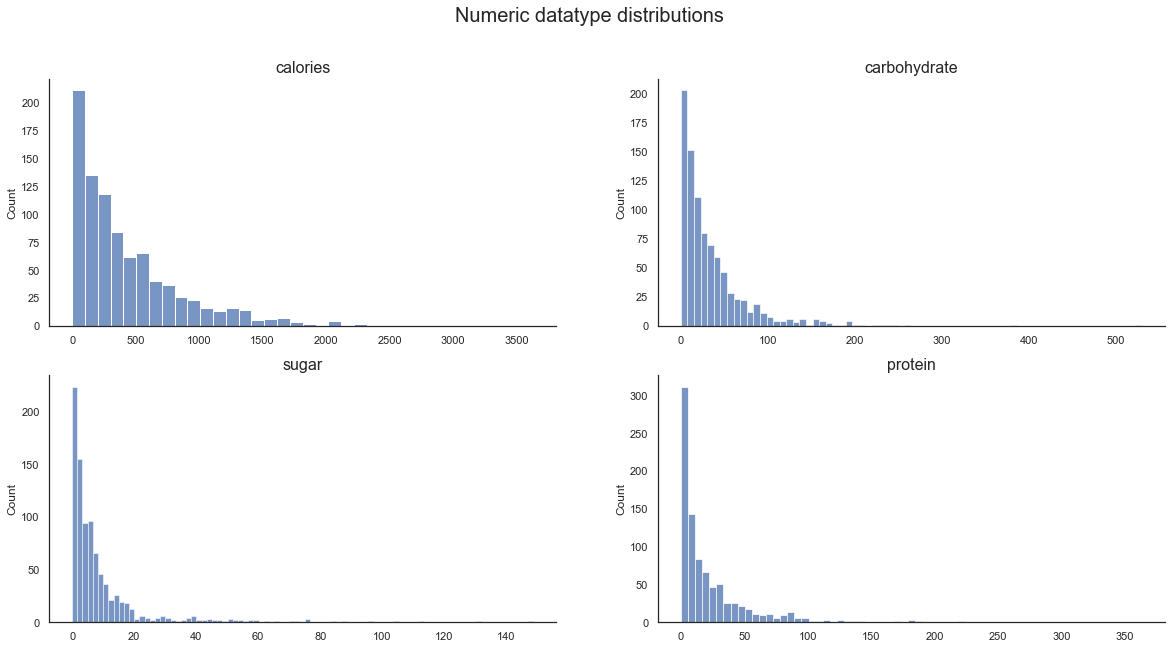

In [3]:
# print 4 graphs of a single-variable distribution plot : one for each of four numeric variables  # CRITERIA A (single variable): 1/2
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    sns.despine()
    fig.suptitle('Numeric datatype distributions', fontsize=20)
    for i, col in enumerate(df.columns[:4]):
        ax = axes.flat[i]
        sns.histplot(data=df, x=df[col], kde=False, ax=ax)
        ax.set_title(col)
        ax.set_xlabel(None)
    fig.savefig('numeric_distributions.png')
        

Graphs are confirming our assumption on previous <code>df_stats</code> dataframe : all four numeric distributions are right skewed.<br>
We will need to normalize the distributions before any model-fitting.

##### 1.3.3. Object datatype

Let's first take a look at unique values.

In [4]:
for c in list(df.select_dtypes(include=object).columns):
    print(f'\n{c}:', f'{df[c].nunique()} unique values', 
          f'\n{df[c].value_counts().to_dict()}'
          f'\n nans: {df[c].isna().sum()}')


category: 11 unique values 
{'Breakfast': 106, 'Chicken Breast': 98, 'Beverages': 92, 'Lunch/Snacks': 89, 'Potato': 88, 'Pork': 84, 'Vegetable': 83, 'Dessert': 83, 'Meat': 79, 'Chicken': 74, 'One Dish Meal': 71}
 nans: 0

servings: 6 unique values 
{'4': 389, '6': 197, '2': 183, '1': 175, '4 as a snack': 2, '6 as a snack': 1}
 nans: 0

high_traffic: 1 unique values 
{'High': 574}
 nans: 373


Here is the situation :<br>
<ol>
<li><code>category</code> column :<br>
Wow... This column is actually a mix of :
<ul>
<li>meal-type (breakfast, lunch/snack, one dish meal), 
<li>food-category (vegetable, dessert, meat, beverage),
<li>food-segment or subcategory (chicken breast, chicken, potato, pork)...</li></ul>
Some interrogations raise :
<ul><li>should we split them into 3 new columns ?
<li>should we infer some food-category from detailed food-segment ? like {vegetable: [potato], meat:[chicken breast, chicken, pork]} ?
<li>could daytime impact popularity ?</li></ul>
In order to keep the dataset as close as possible to the raw data before entering the model-design phase, we will make VERY little transformations, without changing the data itself (datatype or dataframe layout only).
<br><br>
<li><code>servings</code> column :<br>
Only 3 recipes with this classification "as a snack"...<br>
<ul><li>should "4 as a snack" be assimilated to "4" (same question for 6) ?
<li>does it mean all other 'Lunch/Snacks' are 'Lunch' ?</li></ul>
<br>
<li><code>high_traffic</code> column :<br>
This last column will act as the final Label is also needing a small clean (replace 'nan'...).</li></ol>

Let us first shape the <code>high_traffic</code> Label to a boolean, and give a look on its relation to other columns distributions.

In [5]:
# high_traffic : replace explicitely NaN values in high_traffic column by a boolean
# TRUE = high traffic
if len(df['high_traffic'].isna().value_counts()) != 1:
    df['high_traffic'] = df['high_traffic'] == 'High'
df.high_traffic.head(5)

recipe
1     True
2     True
3    False
4     True
5    False
Name: high_traffic, dtype: bool

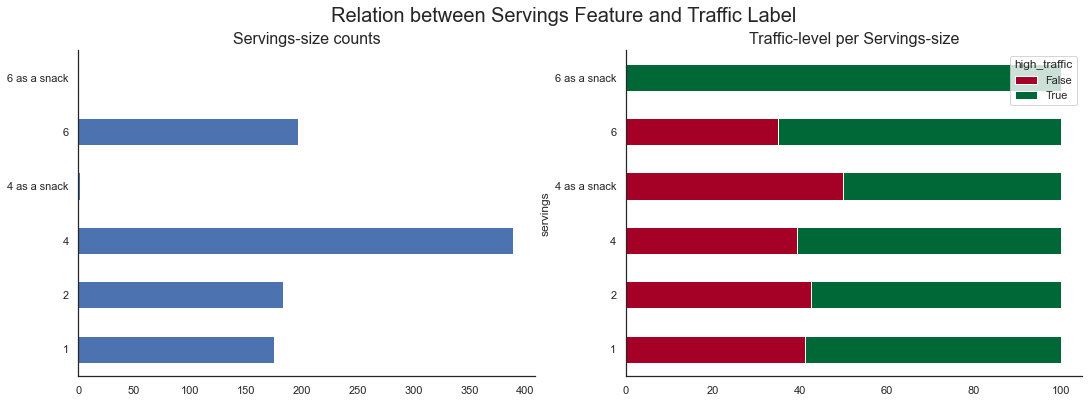

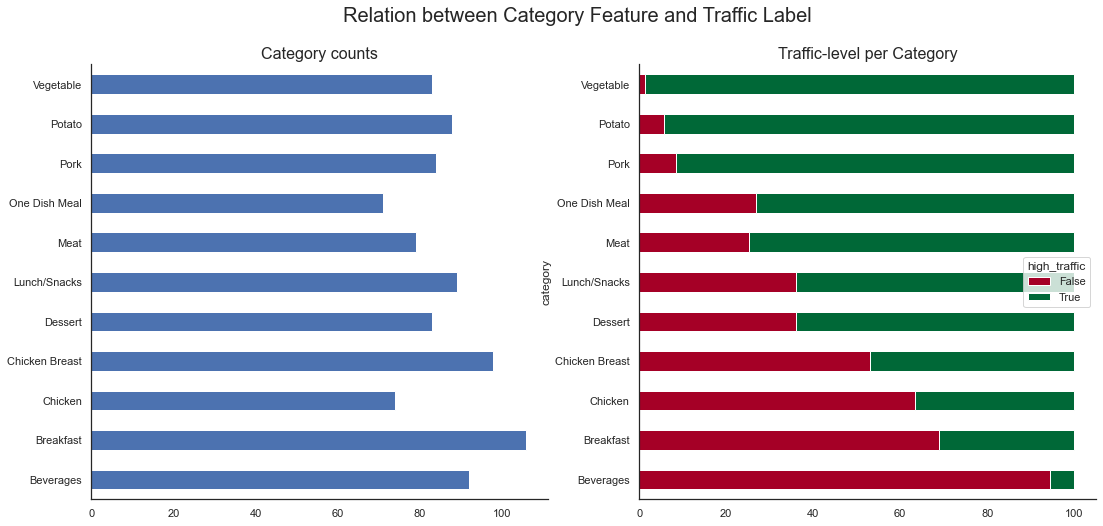

In [6]:
# plot relations between Servings or Category, versus Traffic   # CRITERIA B (multiple variables): 1/1
with sns.axes_style("white"):
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    fig1.suptitle('Relation between Servings Feature and Traffic Label', fontsize=20)
    sns.despine()
    df.servings.value_counts().sort_index().plot(kind='barh', ax=ax1, title='Servings-size counts')
    serv_grouped = df.groupby('servings')['high_traffic'].value_counts(normalize=True).sort_index(level=[0,1], ascending=[True,False]).mul(100)
    serv_grouped.unstack().plot(kind='barh', stacked=True, colormap='RdYlGn', ax=ax2, title='Traffic-level per Servings-size')
    sns.despine()
    fig1.savefig('relation_servings_traffic.png')

    fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
    fig2.suptitle('Relation between Category Feature and Traffic Label', fontsize=20)
    sns.despine()
    df.category.value_counts().sort_index().plot(kind='barh', ax=ax1, title='Category counts')
    cat_grouped = df.groupby('category')['high_traffic'].value_counts(normalize=True).sort_index(level=[0,1], ascending=[True,False]).mul(100)
    cat_grouped.unstack().plot(kind='barh', stacked=True, colormap='RdYlGn', ax=ax2, title='Traffic-level per Category')
    fig2.savefig('relation_category_traffic.png')

The graphs are showing tendencies on both <code>Servings</code> and <code>Category</code> columns :
<li><code>Servings</code> is slightly impactive on traffic level : the bigger the servings are, the most popular the recipe is.<br>
<li>on the other hand, food <code>Category</code> is VERY impactive on traffic level : 
vegetable and pork recipes seem to generate much more traffic than recipes on breakfast or beverages</li>

As a conclusion, it could be a good idea to make a <b>stratified</b> train_test_split, rather than a classical random train_test_split : with this little trick, we will make sure to keep those tendencies equal in train AND test sets.

In [7]:
# servings : quick look
df[df.servings.str.contains('snack')]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,True
549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,True
736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,False


'4/6 as a snack' servings all belong to 'Lunch/Snacks' category. Let's have a look on this category.

In [8]:
# we use median to consider numeric data is skewed
lunch_snacks = df[df.category == 'Lunch/Snacks'].groupby('servings').agg({'servings':'count', 'calories': ['median', 'max'], 'sugar': ['median', 'max']})
lunch_snacks

servings  calories            sugar       
                count    median      max  median    max
servings                                               
1                  17   515.490  1435.35   2.820  17.09
2                  15   362.780  1243.90   1.890  22.39
4                  34   299.140  1266.75   2.350  30.60
4 as a snack        2  1028.140  1542.53  12.170  18.63
6                  20   303.305   850.16   2.945  15.64
6 as a snack        1  1440.690  1440.69   5.780   5.78

servings calories           sugar        
            count   median      max median     max
servings                                          
1             175  336.130  2332.32  3.930  148.75
2             183  310.215  2081.69  4.370  131.39
4             389  262.290  3633.16  4.710  112.24
6             197  290.250  2906.01  4.735   86.97

servings calories           sugar       
                count   median      max median    max
servings                                             
4 as a snack        2  1028.14  1542.53  12.17  18.63
6 as a snack        1  1440.69  1440.69   5.78   5.78

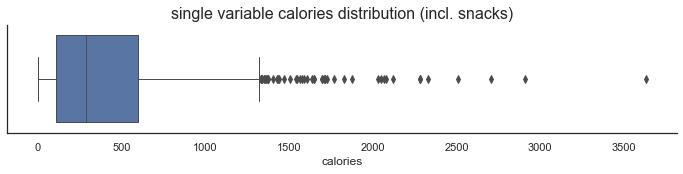

In [9]:
# In comparison with a complete overview the single 'calories' variable...
all_but_snacks = df[~df.servings.str.contains('snack')].groupby('servings').agg({'servings':'count', 'calories': ['median', 'max'], 'sugar': ['median', 'max']})
display(all_but_snacks)
snacks = df[df.servings.str.contains('snack')].groupby('servings').agg({'servings':'count', 'calories': ['median', 'max'], 'sugar': ['median', 'max']})
display(snacks)

# print a graph of a single-variable distribution plot as a boxplot  # CRITERIA A (single variable): 2/2
with sns.axes_style("white"):
    fig1, ax = plt.subplots(figsize=(12,2))
    sns.despine()
    ax = sns.boxplot(data = df, x = 'calories')
    ax.set_title('single variable calories distribution (incl. snacks)')
    plt.savefig('single_var_calories_boxplot.png')

Looking at calories and sugar-levels for <code>Lunch/Snacks</code> category, 'as a snack' servings appears to be very specific (actually outliers...) among 'Lunch/Snacks' category... and with a very few count<br>
We can assume that the other types of 'Lunch/Snacks' should certainly be 'Lunch'. <br><br>
As we have a relatively small dataset (nobs <1000), it should be usefull to further run cross-validations on the models we will design, in order to mitigate the evaluation results. Therefore we will create a Testing, Training and Validation sets.<br>
Each of them should ideally include all category-servings combinations in order to correctly run the process, so we will need to stratify our splits. <br><br>
Anyway, having only 1, or even 2 in the case of <code>4 as a snack</code> unique combinations should get us in troubles downsizing the number of folds we will be able to build. If we observe carefully the data :<br>
<ol>
<li>The <code>6 as a snack</code> category has a unique outcome (high traffic) and is in addition a big outlier among <code>6</code> servings in terms of calories : it is certainly more prudent to simply drop it otherwise it would generate a bias among the <code>6</code> category<br><br>
<li>The <code>4 as a snack</code> category has a count of only 2, so there will not be enough of this kind of samples to balance their proportion between train and test/validation sets...<br>
We can observe that the median values of <code>4 as a snack</code> in terms of calories/sugar do not exceed the maximums of <code>4</code> servings category :
    <ul><li>there is a room to reclassify them as <code>4</code> servings with a minimum bias since they are balanced between True & False for the Label outcome
    <li>other options like simply drop them both, or even bootstrap some fictive samples from them would generate - in our opinion - more bias </li>
    => we will re-classify them as being <code>4</code> servings (it's not completely false...)</ul>
</li>
</ol>

In [10]:
# Since we will transform a little bit our dataframe, we'll make a copy of it here
df_untransformed = df.copy()

# re-arrange 'as snack' servings
df = df[df['servings'] != '6 as a snack']   # dropping '6 as a snack'
df['servings'] = df['servings'].str.replace('4 as a snack', '4')   # replacing '4 as a snack' by '4'

# casting 'category' and 'servings' as category - 'servings' could be set as ordinal
df['servings'] = df['servings'].astype('category').cat.set_categories(['1', '2', '4', '6'], ordered=True)
df['category'] = df['category'].astype('category')
df.servings[:3]

recipe
1    6
2    4
3    1
Name: servings, dtype: category
Categories (4, object): ['1' < '2' < '4' < '6']

In [11]:
# checking new dtypes
df.dtypes

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings        category
high_traffic        bool
dtype: object

#### 1.4. Conclusion & promising imputation and tranformations

The particularity of our dataset is that :
<li>it is missing some datapoints
<li>the size of the dataset is relatively limited</li><br>
That means that we will have to find imputation strategies to fill-in missing values, in order to finally correctly predict probabilities on our Labels.<br>
At this time, we are thinking about four strategies to do it :
<ol>
    <li>The simpliest way would be to classically impute a 'mean' (that could also be a median, a mode, etc.) on each missing datapoint in each column
    <ul>-> the main pitfall is that we would not take into consideration possibles clusters</ul><br>
    <li>As a valuable alternative we could use a KNN Imputer to automate imputation with a KNN algorithm<br><br>
    <li>Another alternative could be to 'simple' impute in a stratified manner ; here it makes sense on <code>category</code><br><br>
    <li>Last but not least, we could define a custom supervised learning algorithm to do it :
        <ul>
        <li>typically a Linear (regularized or not...) regression model predicting missing numeric variables, given the existing ones and our categorical variables
        <li>anyway the input is quite weak : only the <code>category</code> variable seems to be usefull ; some feature engineering might help extracting further information (like clusters) and thus produce a more reliable input for our regression model using unsupervised techniques (KMeans or Hierarchical clustering)</li>
        </ul>
    </li><br>
</ol>

Let's go now deeper into the EDA to see if we could extract more info and find interesting imputation and transformation strategies.

### 2\. Exploratory Data Analyis

#### 2.1. Splitting Features from Target

We will first split our dataset into a train and a test set, keeping the second one appart for final testing.<br>
Making detailed EDA on training set only will avoid us so-called 'data snooping'.

In [12]:
# define features and label columns
FEATURES = ['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']
LABEL = ['high_traffic']
NUM_FEATURES = ['calories', 'carbohydrate', 'sugar', 'protein']
CAT_FEATURES = ['category']
ORD_FEATURES = ['servings']

In [13]:
from sklearn.model_selection import train_test_split

##### 2.1.0. Category-stratified train_test_split (FIRST TRY)

In [14]:
# Another possiblity would have been to use StratifiedShuffleSplit
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df.category)

# Features/Labels outputs on Category Stratif
X_train, X_test = train_set[FEATURES], test_set[FEATURES]
y_train, y_test = train_set[LABEL], test_set[LABEL]
print(f'X_train:{X_train.shape}', f'X_test:{X_test.shape}', f'y_train:{y_train.shape}', f'y_test:{y_test.shape}')
X_train.head(1)

X_train:(756, 6) X_test:(190, 6) y_train:(756, 1) y_test:(190, 1)


,calories,carbohydrate,sugar,protein,category,servings
recipe,,,,,,
574,NaN,NaN,NaN,NaN,Lunch/Snacks,4


##### 2.1.1. Category_Servings-stratified train_test_split (FINAL)

In [15]:
# create a combination of category and servings columns
df['cat_serv'] = df['category'].astype(str) + "_" + df['servings'].astype(str)
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic,cat_serv
recipe,,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,True,Pork_6
2,35.48,38.56,0.66,0.92,Potato,4,True,Potato_4
3,914.28,42.68,3.09,2.88,Breakfast,1,False,Breakfast_1
4,97.03,30.56,38.63,0.02,Beverages,4,True,Beverages_4
5,27.05,1.85,0.80,0.53,Beverages,4,False,Beverages_4


In [16]:
train_set, test_set = train_test_split(df, test_size=0.3, stratify=df.cat_serv)
train_set.drop(columns=['cat_serv'], inplace=True)
test_set.drop(columns=['cat_serv'], inplace=True)

# Features/Labels outputs on Category_Servings Stratif
X_train, X_test = train_set[FEATURES], test_set[FEATURES]
y_train, y_test = train_set[LABEL], test_set[LABEL]
print(f'X_train:{X_train.shape}', f'X_test:{X_test.shape}', f'y_train:{y_train.shape}', f'y_test:{y_test.shape}')
display(X_train.head(1), X_test.head(1))

X_train:(662, 6) X_test:(284, 6) y_train:(662, 1) y_test:(284, 1)


,calories,carbohydrate,sugar,protein,category,servings
recipe,,,,,,
834,86.02,31.49,1.27,6.72,Lunch/Snacks,6


,calories,carbohydrate,sugar,protein,category,servings
recipe,,,,,,
339,482.51,26.21,5.29,18.93,Potato,4


In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 339 to 408
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      267 non-null    float64 
 1   carbohydrate  267 non-null    float64 
 2   sugar         267 non-null    float64 
 3   protein       267 non-null    float64 
 4   category      284 non-null    category
 5   servings      284 non-null    category
dtypes: category(2), float64(4)
memory usage: 12.2 KB


#### 2.2. Deep-insight of data (scaled distributions, correlations)

We've seen in previous chapter that there is about 5% missing data in numeric columns.<br>
In order not to loose precious data on categorical columns corresponding to those records, a good option would be to impute values, but how should we do it ?

##### 2.2.1. missing data

In [18]:
train_set.isna().sum()

calories        35
carbohydrate    35
sugar           35
protein         35
category         0
servings         0
high_traffic     0
dtype: int64

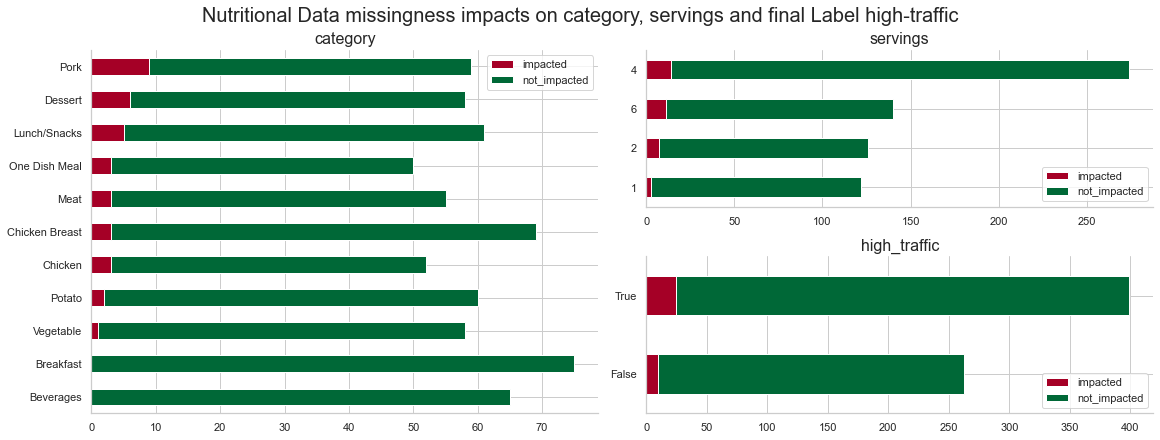

In [90]:
# as all 4 numeric values are missing on the same records

train_filled = train_set[~train_set.calories.isna()]
train_empty = train_set[train_set.calories.isna()]

with sns.axes_style("whitegrid"):
    fig = plt.figure(constrained_layout=True, figsize=(16,6))
    fig.suptitle('Nutritional Data missingness impacts on category, servings and final Label high-traffic', fontsize=20)
    gs = fig.add_gridspec(2, 2)
    
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    axes = [ax1, ax2, ax3]

    #fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,10))
    sns.despine()
    for i, c in enumerate(['category', 'servings', 'high_traffic']):
        missingness = pd.DataFrame()
        missingness = missingness.assign(impacted=train_empty[c].value_counts())
        missingness = missingness.assign(not_impacted=train_filled[c].value_counts())
        missingness.sort_values('impacted').plot(kind='barh', stacked=True, ax=axes[i], title=c, colormap='RdYlGn')
        fig.savefig('data_missingness_impacts.png')

Missingness seems to follow a MAR mechanism (except for the 2 "0" in protein which seems to be MCAR). <br>
Indeed, Beverages and Breakfast categories have no missing data, whereas Pork category gets a higher proportion of missing data.<br>
We observe less causality between servings size and data-missingness.<br><br>
A good imputation strategy could be to 'stratify' the imputation at category level, either taking medians or with a more advanced technique like a KNNImputer.

##### 2.2.2. Detailed distributions & correlations

In [20]:
# short reminder
print(f'train_set columns : {train_set.columns}')
print(f'numeric features : {NUM_FEATURES}')

train_set columns : Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings',
       'high_traffic'],
      dtype='object')
numeric features : ['calories', 'carbohydrate', 'sugar', 'protein']


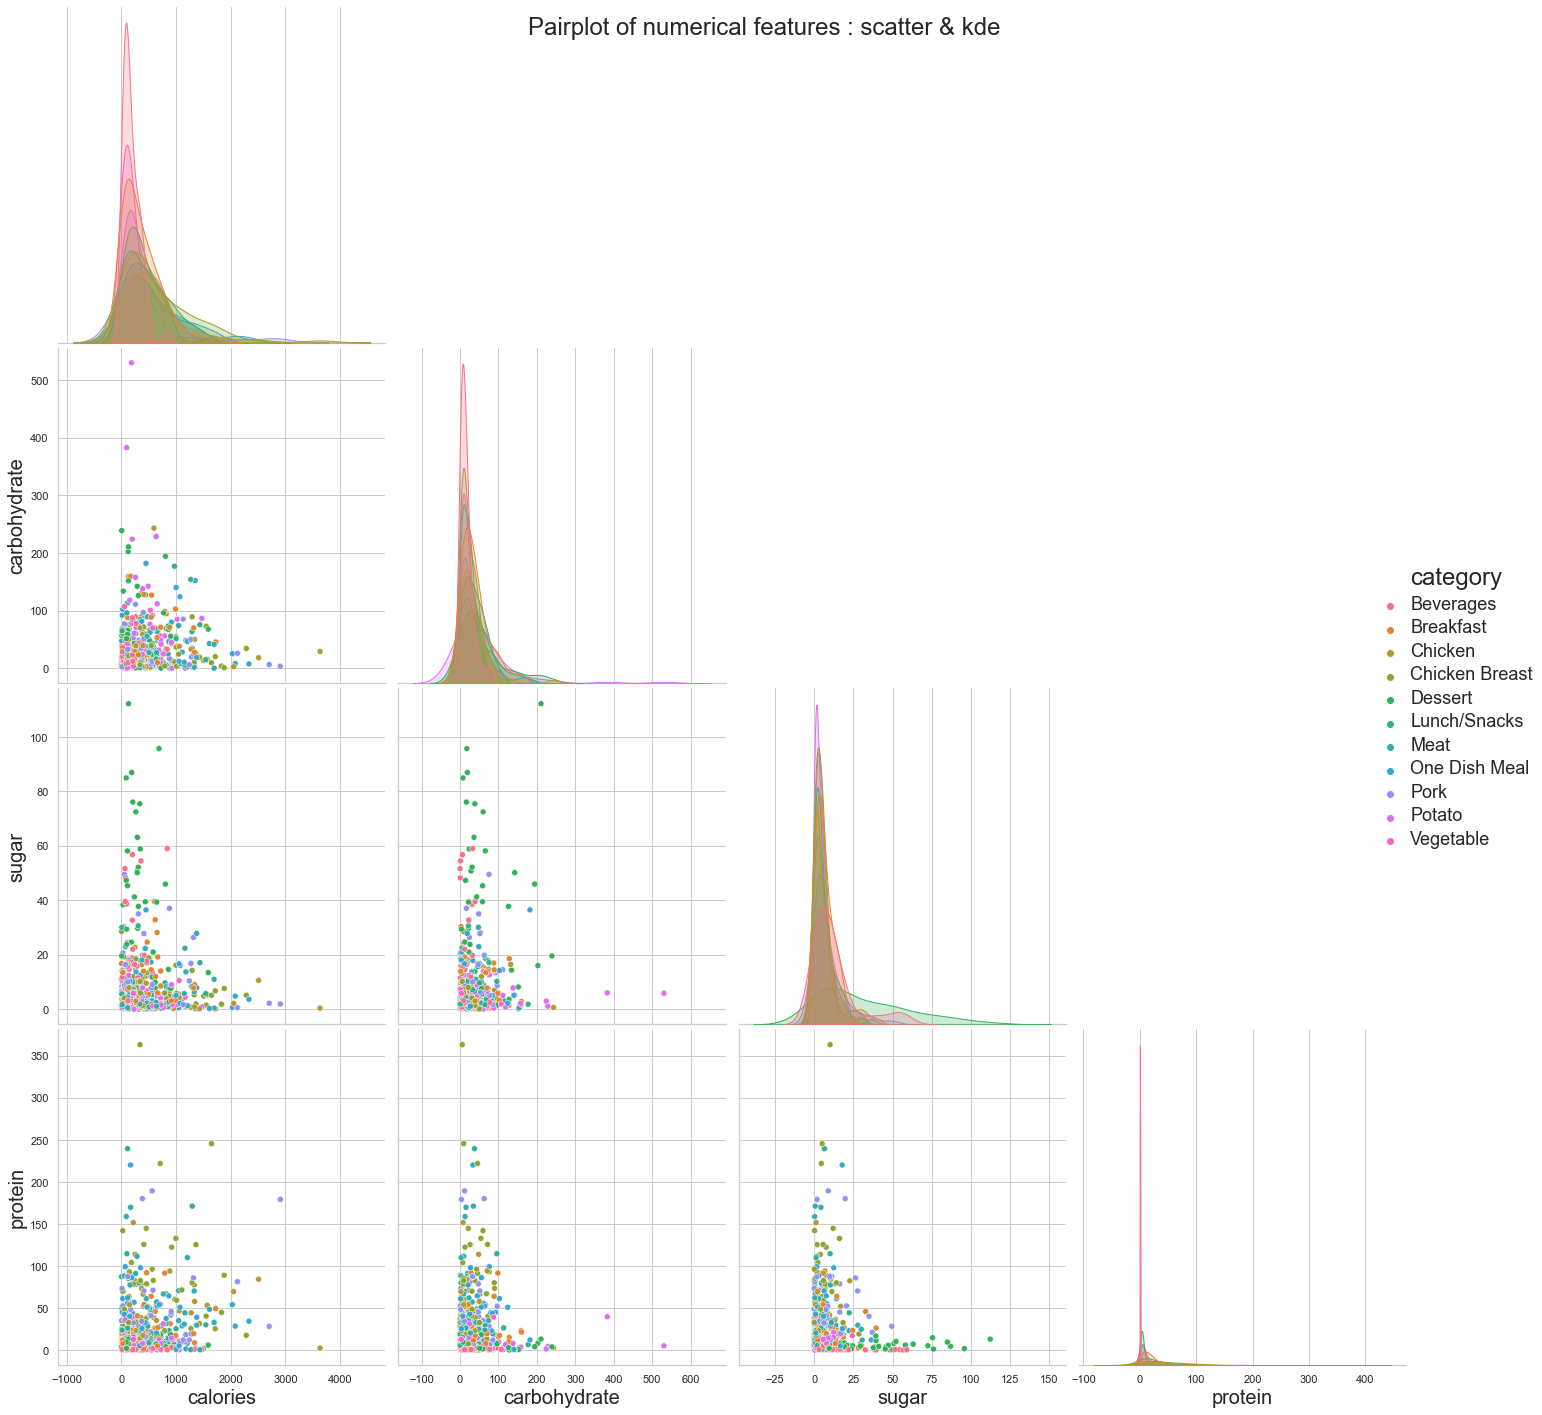

In [21]:
with sns.plotting_context(rc={"axes.labelsize":20}):  # was sns.axes_style("white")
    # see project on music
    pp = sns.pairplot(data = train_set, vars=NUM_FEATURES, hue='category', diag_kind='kde', dropna=True, corner=True, height=5)
    pp.fig.suptitle('Pairplot of numerical features : scatter & kde', fontsize=24)
    plt.setp(pp._legend.get_title(), fontsize=24)  # legend title
    plt.setp(pp._legend.get_texts(), fontsize=18)  # legend text
    fig.savefig('pairplot.png')

We see here that distributions highly depends on categories.<br><br>
The basic scatter matrix shows that numerical, continuous features are highly right-skewed.<br>
They are all showing the same "Lognormal" shape, that would typically need a Box-Cox transformation to make it Gaussian-like.

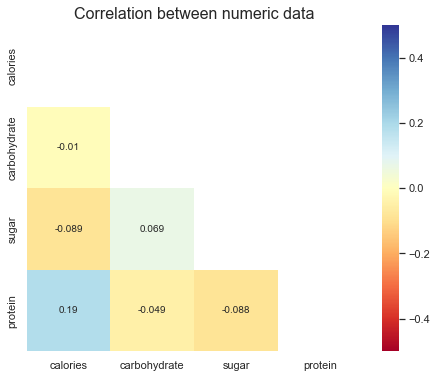

In [22]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(7.5, 6))
    sns.despine()

    # plotting a triangle correlation heatmap
    mask = np.triu(np.ones_like(X_train[NUM_FEATURES].corr()))
    sns.heatmap(X_train[NUM_FEATURES].corr(), cmap="RdYlBu", annot=True, mask=mask, vmin=-0.5, vmax=0.5, ax=ax)
    ax.set_title('Correlation between numeric data')
    fig.savefig('correlation_matrix.png')


The correlation plot shows there isn't much correlation between numeric variables, just being slightly positive between protein and calories.<br>
=> we can assume there is no confounding variable in the dataset.</li>

#### 2.3. Feature engineering

We'll try in this section to make an exploratory clustering on features, to identify potential tendencies.

##### 2.3.1. PCA

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [24]:
# first we need to clean our data
# drop nans
X_train_filled = X_train[NUM_FEATURES].dropna()
X_train_filled.columns

# scale to 0-1 range
stdscaler = StandardScaler()
robscaler = RobustScaler()

X_train_scaled_std = stdscaler.fit_transform(X_train_filled)
X_train_scaled_rob = robscaler.fit_transform(X_train_filled)


In [25]:
# Import PCA class
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca_std, pca_rob = PCA(), PCA()

pca_std.fit(X_train_scaled_std)
pca_rob.fit(X_train_scaled_rob)

exp_variance_std = pca_std.explained_variance_ratio_
exp_variance_rob = pca_rob.explained_variance_ratio_

exp_variance = np.concatenate((exp_variance_std.reshape(1,4), exp_variance_rob.reshape(1,4)), axis=0)
print(exp_variance)

[[0.31664608 0.25237179 0.22860932 0.20237281]
 [0.40127752 0.25906377 0.20774262 0.13191609]]


,calories,carbohydrate,sugar,protein
Std_scaler,31.7,25.2,22.9,20.2
Rob_scaler,40.1,25.9,20.8,13.2


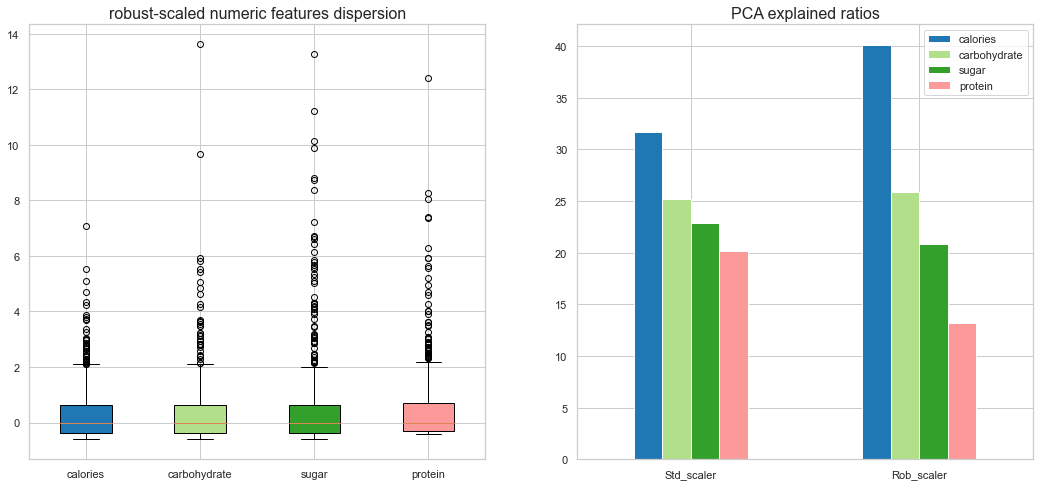

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
colors = [list(matplotlib.cm.get_cmap('Paired').colors)[n] for n in range(1, 5, 1)]

# show outliers
bbplot = ax1.boxplot(X_train_scaled_rob, vert=True, patch_artist=True, labels=X_train_filled.columns)
for patch, color in zip(bbplot['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_title('robust-scaled numeric features dispersion')

# show explained ratios in perc
PCA_ratios = pd.DataFrame(data=exp_variance.round(3)*100, index=['Std_scaler', 'Rob_scaler'], 
             columns=X_train_filled.columns)
PCA_ratios.plot(kind='bar', rot=0, colormap=matplotlib.colors.ListedColormap(colors), ax=ax2, title='PCA explained ratios')
display(PCA_ratios)
fig.savefig('scaler_comparison_PCA-ratios.png')

Without considering segmentation, calories is the main component to explain variance in our features.

##### 2.3.2. categorized crash-PCA on numerical features

Since category impact a lot on final traffic-level as seen in the beginning, it could be interesting to check:
<li>the median values of each category 
<li>how the variance of those means impact PCA</li>

In [27]:
feat_serv_grouped = pd.concat([X_train[NUM_FEATURES], X_train[CAT_FEATURES], X_train[ORD_FEATURES]], axis=1).groupby('servings').median()  # median is used to distribution skewness
feat_cat_grouped = pd.concat([X_train[NUM_FEATURES], X_train[CAT_FEATURES], X_train[ORD_FEATURES]], axis=1).groupby('category').median()  # median is used to distribution skewness
display(feat_serv_grouped, feat_cat_grouped)

,calories,carbohydrate,sugar,protein
servings,,,,
1,368.090,23.79,4.100,15.38
2,293.860,22.47,4.940,8.58
4,264.035,22.81,4.705,13.19
6,288.860,19.64,4.680,7.93


,calories,carbohydrate,sugar,protein
category,,,,
Beverages,125.950,12.050,7.550,0.500
Breakfast,259.830,28.840,4.970,12.530
Chicken,394.550,18.840,2.970,33.170
Chicken Breast,449.625,16.790,4.210,39.480
Dessert,301.490,37.420,20.265,4.380
Lunch/Snacks,352.215,31.985,2.505,10.490
Meat,445.150,21.300,2.955,30.965
One Dish Meal,419.280,25.080,4.780,28.650
Pork,336.495,21.270,5.890,30.695


In [28]:
# a quick calculation of coefficients of variation could help identify the most 'differentiating' features
# see alternative analysis in music project

varcoeff = pd.DataFrame()
cat_dev, serv_dev, cat_mean, serv_mean = feat_cat_grouped.std(), feat_serv_grouped.std(), feat_cat_grouped.mean(), feat_serv_grouped.mean()
varcoeff['cat_varcoeff'] = cat_dev / cat_mean *100
varcoeff['serv_varcoeff'] = serv_dev / serv_mean *100
round(varcoeff, 2)

,cat_varcoeff,serv_varcoeff
calories,37.69,14.77
carbohydrate,35.59,8.03
sugar,88.33,7.76
protein,78.00,31.98


This calculation shows an interesting point:<br>
As 'simple' PCA emphasizes calories, a categorized analysis shows that sugar and protein are also impacting a lot on some specific categories.<br>
We will focus on them for further analysis.

##### 2.3.3. Category-Feature clustering

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [30]:
# let's build our features and labels
CAT_FEATURES_LABELS = feat_cat_grouped.index.values
SELECTED_CAT_FEATURES = feat_cat_grouped[['sugar', 'protein']].values  # was 'sugar', 'protein'

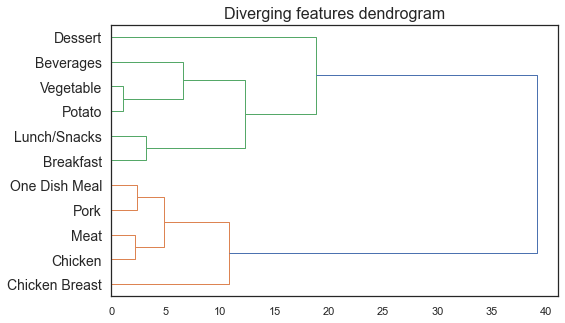

In [31]:
# TO DO : correct dendrogram to show AgglomerativeClustering result / switch to 4 levels only ?
# showing dendrogram
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,5))
    mergings = linkage(SELECTED_CAT_FEATURES, method='complete', optimal_ordering =True)  # was previously only sugar and protein (CAT_FEATURES_VALS)
    dendrogram(mergings, labels=list(CAT_FEATURES_LABELS), leaf_font_size=14, orientation='right', ax=ax, truncate_mode='level', p=4)
    ax.set_title('Diverging features dendrogram')
    fig.savefig('category_dendrogram.png')

This dendrogram shows us some categories hierarchy, like :
<li>Meats & One Dish Meal form a first cluster
<li>Fruits, vegetables, Breakfast & Lunch/Snacks form a second cluster
<li>Dessert category lies in a separate cluster</li><br>
Those namings should certainly be validated by the Product department, also just giving them a cluster number will be sufficient for us.

This dendrogram is just a visualisation but we will use sklearn AgglomerativeClustering (with the same linkage method...) to get labels easily.

In [32]:
# use sklearn clustering & visualizing list of labels
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(SELECTED_CAT_FEATURES)
pairs = pd.DataFrame({'category': list(CAT_FEATURES_LABELS), 'cluster': clustering.labels_}).sort_values('cluster')
category_mapping = pairs.set_index('category').to_dict()['cluster']
category_mapping

{'Beverages': 0,
 'Breakfast': 0,
 'Lunch/Snacks': 0,
 'Potato': 0,
 'Vegetable': 0,
 'Chicken': 1,
 'Chicken Breast': 1,
 'Meat': 1,
 'One Dish Meal': 1,
 'Pork': 1,
 'Dessert': 2}

In [33]:
# X_train modified
X_train_clustered = X_train.copy()
X_train_clustered['cluster'] = X_train_clustered['category'].map(category_mapping).astype('category')
X_train_clustered

,calories,carbohydrate,sugar,protein,category,servings,cluster
recipe,,,,,,,
834,86.02,31.49,1.27,6.72,Lunch/Snacks,6,0
277,0.76,1.90,3.76,0.05,Vegetable,2,0
496,1177.94,48.25,0.78,18.30,Pork,2,1
499,470.68,2.71,3.92,31.40,Breakfast,1,0
275,858.67,5.07,7.47,1.84,Lunch/Snacks,1,0
...,...,...,...,...,...,...,...
882,219.25,3.19,5.82,12.75,Vegetable,4,0
233,207.37,12.05,22.03,0.38,Beverages,4,0
517,264.13,39.05,2.97,23.04,Chicken,4,1


#### 2.4. Imputation of missing values

##### 2.4.1. Imputing MCAR missing values with KNN Imputer (TEST)

In [34]:
from sklearn.impute import KNNImputer

KNNimp = KNNImputer(missing_values=float(0), n_neighbors=5)
# to complete

In [35]:
knnimputed = KNNimp.fit_transform(X_train.dropna()[NUM_FEATURES])
X_train_knnimputed = pd.DataFrame(knnimputed, index=X_train.dropna().index)
X_train_knnimputed

,0,1,2,3
recipe,,,,
834,86.02,31.49,1.27,6.72
277,0.76,1.90,3.76,0.05
496,1177.94,48.25,0.78,18.30
499,470.68,2.71,3.92,31.40
275,858.67,5.07,7.47,1.84
...,...,...,...,...
882,219.25,3.19,5.82,12.75
233,207.37,12.05,22.03,0.38
517,264.13,39.05,2.97,23.04


We need to drop nans for the KNN to work correctly loosing somehow 5% of the observations.<br>
Let's try another method.

##### 2.4.2. Imputing missing values with SimpleImputer iterated on categories

In order not to introduce bias by transforming incomplete variable, we will stay on a direct imputation strategy.<br>
But what can be done easily is to choose a particular strategy taking into account :
<ol>
<li>the skewness of all numeric variables
<li>the heterogeneity in missing datapoints between categories (the categories having been proven to highly impact traffic)</li></ol>
Therefore we could imagine an simple median imputation iterated over each category (imp1) and a second imputation iterated over each cluster (imp2).<br>
<code>servings</code> is not suspected to impact as much as <code>category</code> on numerical values<br>

In [36]:
from sklearn.impute import SimpleImputer

In [37]:
category_vals = list(df['category'].unique())   # USED IN PREDICTING MODEL

In [38]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame()

for k in category_vals:
    section_transformed = pd.DataFrame(imputer.fit_transform(X_train.iloc[:, :4][X_train.category == k]), index=X_train.iloc[:, :4][X_train.category == k].index)
    X_train_imputed = pd.concat([X_train_imputed, section_transformed], axis=0)

X_train_imputed = pd.concat([X_train_imputed.reindex(X_train.index), X_train.iloc[:, 4:]], axis=1).rename(columns={0:'calories', 1:'carbohydrate', 2:'sugar', 3:'protein'})
X_train_imputed

,calories,carbohydrate,sugar,protein,category,servings
recipe,,,,,,
834,86.02,31.49,1.27,6.72,Lunch/Snacks,6
277,0.76,1.90,3.76,0.05,Vegetable,2
496,1177.94,48.25,0.78,18.30,Pork,2
499,470.68,2.71,3.92,31.40,Breakfast,1
275,858.67,5.07,7.47,1.84,Lunch/Snacks,1
...,...,...,...,...,...,...
882,219.25,3.19,5.82,12.75,Vegetable,4
233,207.37,12.05,22.03,0.38,Beverages,4
517,264.13,39.05,2.97,23.04,Chicken,4


#### 2.5. Promising further transformations

Now that we imputed carrefully missing values, further transformations focus will be :
<ol>
<li>Scaling numerical features : PowerTransformer (box-cox) is targeted
<li>Encode categorical features : OneHot / Ordinal Encoder are targeted
<li>Union numerical & categorical features : FeatureUnion
<li>Developing a baseline model, then a comparison model:
    <ul>
    <li>LogisticRegression model
    <li>ensemble model</li></ul></li></ol>
Then, the next steps will be to evaluate and show how our two models compare (accuracy/f1, ROC_AUC).<br>
Then, set the predictions (=probabilities) of each label with predic_proba method


### 3\. Preprocessing

In [39]:
# Import functional utilities
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Import preprocessing encoders and scalers
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer

As proposed before we will apply a sequence of transformations to our data.<br>
The best way to do it is to build a preprocessing pipeline :
<ul>
<li>handling ordinal-category features : <code>'ordinal_pipeline'</code>
    <ol>
    <li><code>ordselector</code> mapping to <code>get_ordinal_data</code> custom function
    <li><code>ordencoder</code> mapping to OrdinalEncoder (servings)</li></ol><br>
<li>handling nominal-category features : <code>'categorical_pipeline'</code>
    <ol>
    <li><code>catselector</code> mapping to <code>get_categorical_data</code> custom function
    <li><code>ohencoder</code> mapping to OneHotEncoder (category + eventually cluster) </li></ol><br>
<li>handling numerical features : <code>'numeric_pipeline'</code>
    <ol>
    <li><code>numselector_imputer</code> mapping to <code>get_impute_numeric_cols</code> :
        <ul>a custom function grouping extraction + a custom imputer with a category-level
        <li>baseline : Custom_imputer, that extract numeric data, filtered on k categories and loop imputer on each category
        <li>alternative OR additional : KNNImputer (n_neighbors=5) to handle other sparse missing data</li></ul>
    <li><code>scaler</code> using PowerTransformer with 'Box-Cox' method, as data is positive</li></ol><br>
<li>unioning all kind of features (ordinal, nominal and numeric) :
    <ul>
    <li><code>union</code> mapping to FeatureUnion (servings)</li></ul>


In [40]:
CAT_FEATURES_EXTENDED = ['category', 'cluster']

#### 3.1. Custom Transformers

In [41]:
def cluster_category(X):
    """propose a 3-levels clustering of 'category' column, between 0 and 2."""

    if type(X) == pd.DataFrame:
        categories = list(np.unique(X.values[:,4]))
    else:
        categories = list(np.unique(X[:,4]))
        X = pd.DataFrame(X)

    X['cluster'] = X.iloc[:,4].map(category_mapping).astype('category')
    
    return X


def get_impute_numeric_cols(X):
    """get numeric columns and use a custom_imputer to impute medians repeated on each category"""    

    imputer = SimpleImputer(strategy='median')

    if type(X) == pd.DataFrame:
        categories = list(np.unique(X.values[:,4]))
    else:
        categories = list(np.unique(X[:,4]))
        X = pd.DataFrame(X)

    X_imputed = pd.DataFrame()

    for k in categories:
        section_imputed = pd.DataFrame(
            imputer.fit_transform(X[X.iloc[:,4] == k].iloc[:,:4]),   # slice on category without using column names
            index=X[X.iloc[:,4] == k].index)   # keeping track on indices 
        
        X_imputed = pd.concat([X_imputed, section_imputed], axis=0)

    X_imputed = X_imputed.reindex(X.index).rename(columns={0:'calories', 1:'carbohydrate', 2:'sugar', 3:'protein'})

    return X_imputed

In [42]:
# additional clustering pre-processing
cluster_data = FunctionTransformer(cluster_category, validate=False)

# customized feature selection
get_numeric_data = FunctionTransformer(get_impute_numeric_cols, validate=False)
get_ordinal_data = FunctionTransformer(lambda x: x[ORD_FEATURES] if type(x) == pd.DataFrame else x[:,5].reshape(-1,1), validate=False)

get_categorical_data = FunctionTransformer(lambda x: x[CAT_FEATURES] if type(x) == pd.DataFrame else x[:,4].reshape(-1,1), validate=False)   # do not catch 'cluster' column
get_categorical_data_extended = FunctionTransformer(lambda x: x[CAT_FEATURES_EXTENDED] if type(x) == pd.DataFrame else x[:,[4,6]], validate=False)   #catch 'cluster' column

#### 3.2. Usual Transformers

Let's see at a glance what a PowerTransformer would generate on your numeric data. 

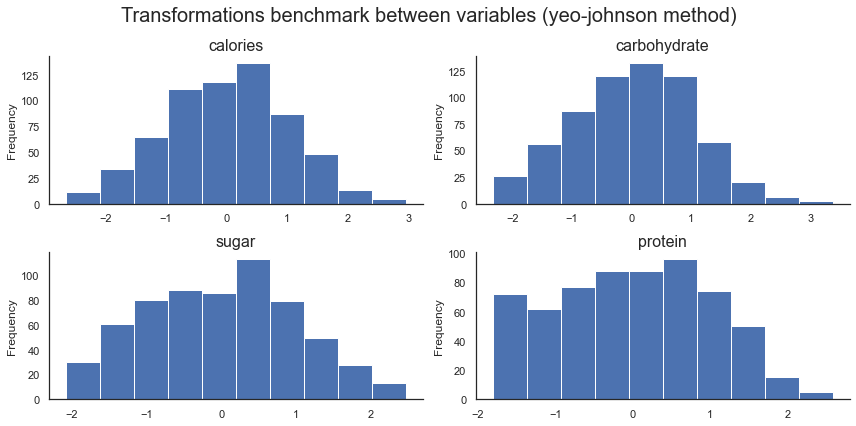

In [43]:
from sklearn.preprocessing import PowerTransformer

test_powertransf = PowerTransformer()
simply_transformed1 = test_powertransf.fit_transform(X_train[NUM_FEATURES])
simply_transformed2 = pd.DataFrame(simply_transformed1, columns=X_train[NUM_FEATURES].columns)

with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
    fig.suptitle('Transformations benchmark between variables (yeo-johnson method)', fontsize=20)
    sns.despine()
    simply_transformed2.iloc[:,0].plot(kind='hist', ax=axes[0, 0], title=simply_transformed2.columns[0])
    simply_transformed2.iloc[:,1].plot(kind='hist', ax=axes[0, 1], title=simply_transformed2.columns[1])
    simply_transformed2.iloc[:,2].plot(kind='hist', ax=axes[1, 0], title=simply_transformed2.columns[2])
    simply_transformed2.iloc[:,3].plot(kind='hist', ax=axes[1, 1], title=simply_transformed2.columns[3])
    fig.tight_layout()
    fig.savefig('transformed_numeric_data.png')
    

After transformations, we have roughly Gaussian distributions.<br>
Protein is the only variable which the Transformer has a bit difficulties to convert.

In [44]:
# for ordinal and categorical dtypes
ordencoder = OrdinalEncoder()
ohencoder = OneHotEncoder()
ohencoder_extended = OneHotEncoder()

# for numeric dtypes
knnimputer = KNNImputer(missing_values=float(0), n_neighbors=5)
powertransformer = PowerTransformer(method='yeo-johnson')
#standardscaler = StandardScaler()


#### 3.3. Preprocessing pipeline

In [45]:
# column selection

ordinal_pipeline = Pipeline([
    ('ordselector', get_ordinal_data),
    ('ordencoder', ordencoder)])

categorical_pipeline = Pipeline([
    ('catselector', get_categorical_data),
    ('ohencoder', ohencoder)])

categorical_pipeline_extended = Pipeline([
    ('catselector', get_categorical_data_extended),
    ('ohencoder_extended', ohencoder_extended)])

numeric_pipeline = Pipeline([
    ('numselector_imputer', get_numeric_data),
    ('powertransformer', powertransformer)])

numeric_pipeline_extended = Pipeline([
    ('numselector_imputer', get_numeric_data),
    ('knnimputer', knnimputer),
    ('powertransformer', powertransformer)])

In [46]:
# preprocession PL (base)
preprocessing_pipeline = Pipeline([
    ('union', FeatureUnion([
        ('ordinalpl', ordinal_pipeline),   # include ordselector & ordencoder
        ('categoricalpl', categorical_pipeline),   # include catselector (1 var) & ohencoder
        ('numericpl', numeric_pipeline)])  # include numselector_imputer, knnimputer & stdscaler
    )])
preprocessing_pipeline

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('ordinalpl',
                                                 Pipeline(steps=[('ordselector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                 ('ordencoder',
                                                                  OrdinalEncoder())])),
                                                ('categoricalpl',
                                                 Pipeline(steps=[('catselector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224A23E6290>)),
                                                                 ('ohencoder',
                                                                  OneHotEncoder())])),
                                                ('numericpl',
                                                 Pipeline(steps=[('numselector_imputer',
                                                                  FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                 ('powertransformer',
                                                                  PowerTransformer())]))]))])

In [47]:
# preprocession PL (extended)
preprocessing_pipeline_extended = Pipeline([
    ('clusterer', cluster_data),
    ('union', FeatureUnion([
        ('ordinalpl', ordinal_pipeline),   # include ordselector & ordencoder
        ('categoricalpl_extended', categorical_pipeline_extended),   # include catselector (2 vars) & ohencoder
        ('numericpl_extended', numeric_pipeline_extended)])   # include numselector_imputer, knnimputer & powerscaler
    )])
preprocessing_pipeline_extended

Pipeline(steps=[('clusterer',
                 FunctionTransformer(func=<function cluster_category at 0x00000224A23E6170>)),
                ('union',
                 FeatureUnion(transformer_list=[('ordinalpl',
                                                 Pipeline(steps=[('ordselector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                 ('ordencoder',
                                                                  OrdinalEncoder())])),
                                                ('categoricalpl_extended',
                                                 Pipeline(steps=[('catselector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000224A23E6320>)),
                                                                 ('ohencoder_extended',
                                                                  OneHotEncoder())])),
                                                ('numericpl_extended',
                                                 Pipeline(steps=[('numselector_imputer',
                                                                  FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                 ('knnimputer',
                                                                  KNNImputer(missing_values=0.0)),
                                                                 ('powertransformer',
                                                                  PowerTransformer())]))]))])

### 4\. Model development

#### 4.1. Logistic-Regression baseline model

In [48]:
# Import classifier
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg_extended = LogisticRegression()

In [49]:
pipeline_lr = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('logreg', logreg)])
pipeline_lr

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('union',
                                  FeatureUnion(transformer_list=[('ordinalpl',
                                                                  Pipeline(steps=[('ordselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                                  ('ordencoder',
                                                                                   OrdinalEncoder())])),
                                                                 ('categoricalpl',
                                                                  Pipeline(steps=[('catselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E6290>)),
                                                                                  ('ohencoder',
                                                                                   OneHotEncoder())])),
                                                                 ('numericpl',
                                                                  Pipeline(steps=[('numselector_imputer',
                                                                                   FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                                  ('powertransformer',
                                                                                   PowerTransformer())]))]))])),
                ('logreg', LogisticRegression())])

In [50]:
pipeline_lr_extended = Pipeline([
    ('preprocessing_extended', preprocessing_pipeline_extended),
    ('logreg_extended', logreg_extended)])
pipeline_lr_extended

Pipeline(steps=[('preprocessing_extended',
                 Pipeline(steps=[('clusterer',
                                  FunctionTransformer(func=<function cluster_category at 0x00000224A23E6170>)),
                                 ('union',
                                  FeatureUnion(transformer_list=[('ordinalpl',
                                                                  Pipeline(steps=[('ordselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                                  ('ordencoder',
                                                                                   OrdinalEncoder())])),
                                                                 ('categoricalpl_exte...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E6320>)),
                                                                                  ('ohencoder_extended',
                                                                                   OneHotEncoder())])),
                                                                 ('numericpl_extended',
                                                                  Pipeline(steps=[('numselector_imputer',
                                                                                   FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                                  ('knnimputer',
                                                                                   KNNImputer(missing_values=0.0)),
                                                                                  ('powertransformer',
                                                                                   PowerTransformer())]))]))])),
                ('logreg_extended', LogisticRegression())])

#### 4.2. Ensemble-learning alternative model

In [51]:
# Import classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50)  # use eventually more estimators
pipeline_rf = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('rf', rf)])
pipeline_rf

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('union',
                                  FeatureUnion(transformer_list=[('ordinalpl',
                                                                  Pipeline(steps=[('ordselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                                  ('ordencoder',
                                                                                   OrdinalEncoder())])),
                                                                 ('categoricalpl',
                                                                  Pipeline(steps=[('catselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E6290>)),
                                                                                  ('ohencoder',
                                                                                   OneHotEncoder())])),
                                                                 ('numericpl',
                                                                  Pipeline(steps=[('numselector_imputer',
                                                                                   FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                                  ('powertransformer',
                                                                                   PowerTransformer())]))]))])),
                ('rf', RandomForestClassifier(n_estimators=50))])

#### 4.3. Models fitting and predicting

In [52]:
print(f'X_train shape: {X_train.shape}', f'y_train shape: {y_train.shape}')
print('\nX_train nans')
print(X_train.isna().sum())

X_train shape: (662, 6) y_train shape: (662, 1)

X_train nans
calories        35
carbohydrate    35
sugar           35
protein         35
category         0
servings         0
dtype: int64


In [53]:
# single Logistic Regression model 
pipeline_lr.fit(X_train, y_train.values.ravel())   # was pipeline_lr.fit_transform(X_train, y_train)

# ensemble Random Forest model
pipeline_rf.fit(X_train, y_train.values.ravel())   # was pipeline_rf.fit_transform(X_train, y_train)

# extended Logistic Regression model 
pipeline_lr_extended.fit(X_train, y_train.values.ravel())   # was pipeline_lr.fit_transform(X_train, y_train)

Pipeline(steps=[('preprocessing_extended',
                 Pipeline(steps=[('clusterer',
                                  FunctionTransformer(func=<function cluster_category at 0x00000224A23E6170>)),
                                 ('union',
                                  FeatureUnion(transformer_list=[('ordinalpl',
                                                                  Pipeline(steps=[('ordselector',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E5FC0>)),
                                                                                  ('ordencoder',
                                                                                   OrdinalEncoder())])),
                                                                 ('categoricalpl_exte...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224A23E6320>)),
                                                                                  ('ohencoder_extended',
                                                                                   OneHotEncoder())])),
                                                                 ('numericpl_extended',
                                                                  Pipeline(steps=[('numselector_imputer',
                                                                                   FunctionTransformer(func=<function get_impute_numeric_cols at 0x00000224A23E6200>)),
                                                                                  ('knnimputer',
                                                                                   KNNImputer(missing_values=0.0)),
                                                                                  ('powertransformer',
                                                                                   PowerTransformer())]))]))])),
                ('logreg_extended', LogisticRegression())])

In [54]:
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_lr_extended = pipeline_lr_extended.predict(X_test)

c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [55]:
print('ohencoder.categories:', ohencoder.categories_)

print('\nnumber of outputs per chanel:')
feat_sc = powertransformer.get_feature_names_out()
print('\npowertransformer feature outputs:', feat_sc, len(feat_sc))
feat_ord = ordencoder.get_feature_names_out()
print('ordencoder feature outputs:', feat_ord, len(feat_ord))
feat_oh = ohencoder.get_feature_names_out()
print('\nohencoder feature outputs:', feat_oh, len(feat_oh))

print('\ntotal nb of feature outputs after FeatureUnion (short model):', len(feat_ord) + len(feat_oh) + len(feat_sc)) #+ len(feat_sc))

# for extended pipeline
feat_oh_extended = ohencoder_extended.get_feature_names_out()
print('\nohencoder_extended feature outputs:', feat_oh, len(feat_oh_extended))

print('\ntotal nb of feature outputs after FeatureUnion (extended model):', len(feat_ord) + len(feat_oh_extended) + len(feat_sc))

ohencoder.categories: [array(['Beverages', 'Breakfast', 'Chicken', 'Chicken Breast', 'Dessert',
       'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato',
       'Vegetable'], dtype=object)]

number of outputs per chanel:

powertransformer feature outputs: ['x0' 'x1' 'x2' 'x3'] 4
ordencoder feature outputs: ['servings'] 1

ohencoder feature outputs: ['category_Beverages' 'category_Breakfast' 'category_Chicken'
 'category_Chicken Breast' 'category_Dessert' 'category_Lunch/Snacks'
 'category_Meat' 'category_One Dish Meal' 'category_Pork'
 'category_Potato' 'category_Vegetable'] 11

total nb of feature outputs after FeatureUnion (short model): 16

ohencoder_extended feature outputs: ['category_Beverages' 'category_Breakfast' 'category_Chicken'
 'category_Chicken Breast' 'category_Dessert' 'category_Lunch/Snacks'
 'category_Meat' 'category_One Dish Meal' 'category_Pork'
 'category_Potato' 'category_Vegetable'] 14

total nb of feature outputs after FeatureUnion (extended model): 19


In [56]:
print(f'\ntotal expected features in LogReg Estimator: {logreg.n_features_in_}')
print(f'total expected features in RF Estimator: {rf.n_features_in_}')
print(f'\ntotal expected features in LogReg_extended Estimator: {logreg_extended.n_features_in_}')


total expected features in LogReg Estimator: 16
total expected features in RF Estimator: 16

total expected features in LogReg_extended Estimator: 19


#### 4.4. Basic evaluation

In [57]:
accuracy_lr = pipeline_lr.score(X_test, y_test)
print("Accuracy on pipeline_lr: ", accuracy_lr)

accuracy_rf = pipeline_rf.score(X_test, y_test)
print("Accuracy on pipeline_rf: ", accuracy_rf)

accuracy_lr_extended = pipeline_lr_extended.score(X_test, y_test)
print("Accuracy on pipeline_lr_extended: ", accuracy_lr_extended)

Accuracy on pipeline_lr:  0.7429577464788732
Accuracy on pipeline_rf:  0.6971830985915493
Accuracy on pipeline_lr_extended:  0.7394366197183099


c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


#### 4.5. Predicting probabilities

In [58]:
# call transform on each step of preprocessing_pipeline, then call predict_proba on the final estimator (fit is not called anywhere)

# single LR and LR_extended
y_prob_lr = pipeline_lr.predict_proba(X_test)
y_prob_lr_extended = pipeline_lr_extended.predict_proba(X_test)

# ensemble RF
y_prob_rf = pipeline_rf.predict_proba(X_test)

c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [59]:
prob_results_lr = pd.concat([test_set.reset_index(), pd.DataFrame(y_prob_lr)], axis=1)
prob_results_lr = prob_results_lr.set_index('recipe')

print('results on test set for logreg :\n')
print('mean for True labels: ', prob_results_lr[prob_results_lr.high_traffic == True][1].mean().round(3))
print('mean for False labels: ', prob_results_lr[prob_results_lr.high_traffic == False][0].mean().round(3))

prob_results_lr.round(2).head()

results on test set for logreg :

mean for True labels:  0.72
mean for False labels:  0.568


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,0,1
recipe,,,,,,,,,
339,482.51,26.21,5.29,18.93,Potato,4,True,0.09,0.91
734,215.03,8.86,1.10,3.77,Chicken Breast,1,True,0.51,0.49
291,239.90,51.13,131.39,3.38,Dessert,2,True,0.32,0.68
788,100.83,162.91,0.41,5.68,Potato,6,True,0.10,0.90
476,54.97,3.72,7.26,1.08,Vegetable,4,True,0.05,0.95


In [60]:
prob_results_rf = pd.concat([test_set.reset_index(), pd.DataFrame(y_prob_rf)], axis=1)
prob_results_rf = prob_results_rf.set_index('recipe')

print('results on test set for Random Forest :\n')
print('mean for True labels: ', prob_results_rf[prob_results_rf.high_traffic == True][1].mean().round(3))
print('mean for False labels: ', prob_results_rf[prob_results_rf.high_traffic == False][0].mean().round(3))

prob_results_rf.round(2).head()

results on test set for Random Forest :

mean for True labels:  0.702
mean for False labels:  0.576


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,0,1
recipe,,,,,,,,,
339,482.51,26.21,5.29,18.93,Potato,4,True,0.12,0.88
734,215.03,8.86,1.10,3.77,Chicken Breast,1,True,0.64,0.36
291,239.90,51.13,131.39,3.38,Dessert,2,True,0.40,0.60
788,100.83,162.91,0.41,5.68,Potato,6,True,0.12,0.88
476,54.97,3.72,7.26,1.08,Vegetable,4,True,0.02,0.98


In [61]:
prob_results_lr_extended = pd.concat([test_set.reset_index(), pd.DataFrame(y_prob_lr_extended)], axis=1)
prob_results_lr_extended = prob_results_lr_extended.set_index('recipe')

print('results on test set for extended logreg :\n')
print('mean for True labels: ', prob_results_lr_extended[prob_results_lr_extended.high_traffic == True][1].mean().round(3))
print('mean for False labels: ', prob_results_lr_extended[prob_results_lr_extended.high_traffic == False][0].mean().round(3))

prob_results_lr_extended.round(2).head()

results on test set for extended logreg :

mean for True labels:  0.72
mean for False labels:  0.567


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,0,1
recipe,,,,,,,,,
339,482.51,26.21,5.29,18.93,Potato,4,True,0.09,0.91
734,215.03,8.86,1.10,3.77,Chicken Breast,1,True,0.51,0.49
291,239.90,51.13,131.39,3.38,Dessert,2,True,0.32,0.68
788,100.83,162.91,0.41,5.68,Potato,6,True,0.10,0.90
476,54.97,3.72,7.26,1.08,Vegetable,4,True,0.05,0.95


We can predict the True Labels with a mean of 72% of the time in the - best case - of the Logistic Regression model.<br>
The accuracy of such pipeline is around 75%.<br><br>
Anyway our model has uncertainties in performance, let's now take a closer look to the results and make a cross-validation.

### 5\. Model detailed evaluation

#### 5.1. Classification report & confusion matrix

In [62]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

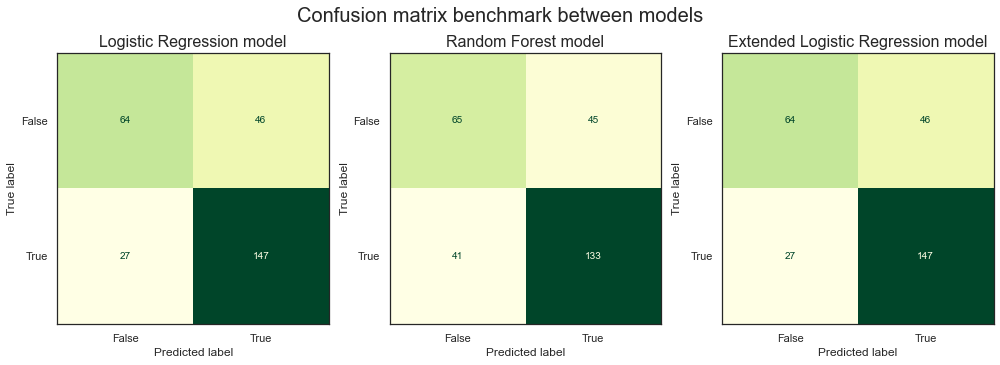

In [63]:
# Compute confusion matrix, accuracy, f1-score (if unbalanced)

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=pipeline_lr.classes_)

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=pipeline_rf.classes_)

cm_lr_extended = confusion_matrix(y_test, y_pred_lr_extended)
cm_lr_extended_display = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=pipeline_lr.classes_)


with sns.axes_style("white"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
    fig.suptitle('Confusion matrix benchmark between models', fontsize=20)

    cm_lr_display.plot(cmap='YlGn', ax=ax1, colorbar=False)
    cm_rf_display.plot(cmap='YlGn', ax=ax2, colorbar=False)
    cm_lr_extended_display.plot(cmap='YlGn', ax=ax3, colorbar=False)
 
    ax1.set_title('Logistic Regression model')
    ax2.set_title('Random Forest model')
    ax3.set_title('Extended Logistic Regression model')

    fig.tight_layout()
    fig.savefig('confusion_matrix.png')


Extended Regression model don't provide usefull improvement versus Short Regression model.<br>
Perhaps hyperparameter tuning could improve.<br>
Anyway, our Logistic Regression model seems better than an ensemble Random Forest model.

In [64]:
# Create the classification report for all models
class_rep_lr = pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True)).reset_index().rename(columns={'index':'metric'})
class_rep_lr['model'] = '1_Log_regression'

class_rep_rf = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).reset_index().rename(columns={'index':'metric'})
class_rep_rf['model'] = '2_Random_forest'

class_rep_lr_extended = pd.DataFrame(classification_report(y_test, y_pred_lr_extended, output_dict=True)).reset_index().rename(columns={'index':'metric'})
class_rep_lr_extended['model'] = '3_Log_regression_extended'

class_rep = pd.concat([class_rep_lr, class_rep_rf, class_rep_lr_extended])  # ,class_rep_bc
class_rep_short = class_rep[class_rep.metric != 'support'].round(2).pivot_table(index=['model', 'metric'])[['False', 'True', 'accuracy', 'macro avg', 'weighted avg']]
class_rep_short

False  True  accuracy  macro avg  \
model                     metric                                        
1_Log_regression          f1-score    0.64  0.80      0.74       0.72   
                          precision   0.70  0.76      0.74       0.73   
                          recall      0.58  0.84      0.74       0.71   
2_Random_forest           f1-score    0.60  0.76      0.70       0.68   
                          precision   0.61  0.75      0.70       0.68   
                          recall      0.59  0.76      0.70       0.68   
3_Log_regression_extended f1-score    0.63  0.80      0.74       0.71   
                          precision   0.70  0.76      0.74       0.73   
                          recall      0.57  0.84      0.74       0.71   

                                     weighted avg  
model                     metric                   
1_Log_regression          f1-score           0.74  
                          precision          0.74  
                          recall             0.74  
2_Random_forest           f1-score           0.70  
                          precision          0.70  
                          recall             0.70  
3_Log_regression_extended f1-score           0.73  
                          precision          0.74  
                          recall             0.74

In [65]:
class_rep_lr

,metric,False,True,accuracy,macro avg,weighted avg,model
0,precision,0.703297,0.761658,0.742958,0.732477,0.739053,1_Log_regression
1,recall,0.581818,0.844828,0.742958,0.713323,0.742958,1_Log_regression
2,f1-score,0.636816,0.801090,0.742958,0.718953,0.737463,1_Log_regression
3,support,110.000000,174.000000,0.742958,284.000000,284.000000,1_Log_regression


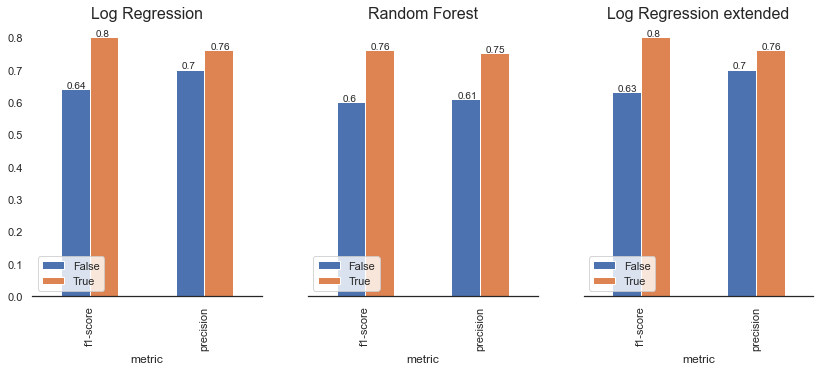

In [77]:
with sns.axes_style("white"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True)
    sns.despine(left=True)
    for (ax, dfs) in zip([ax1, ax2, ax3],[class_rep_lr, class_rep_rf, class_rep_lr_extended]):   #   , ax3   , class_rep_bc
        dfs.round(2).pivot_table(index=['metric']).iloc[:2,:2].plot(kind='bar', ax=ax, legend='reverse')
        ax.legend(loc='lower left')
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() + 0.05, p.get_height() * 1.005))   #
    ax1.set_title('Log Regression')
    ax2.set_title('Random Forest')
    ax3.set_title('Log Regression extended')
    fig.savefig('non-crossed_model_benchmark.png')

The precision of our True Labels predictions is about 80% with the best model, as is the f1-score.<br>
Note that LogReg is slightly more inbalanced then RF => f1-score is usefull.

#### 5.2. ROC curves comparison on models

c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\annea\Programmes\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


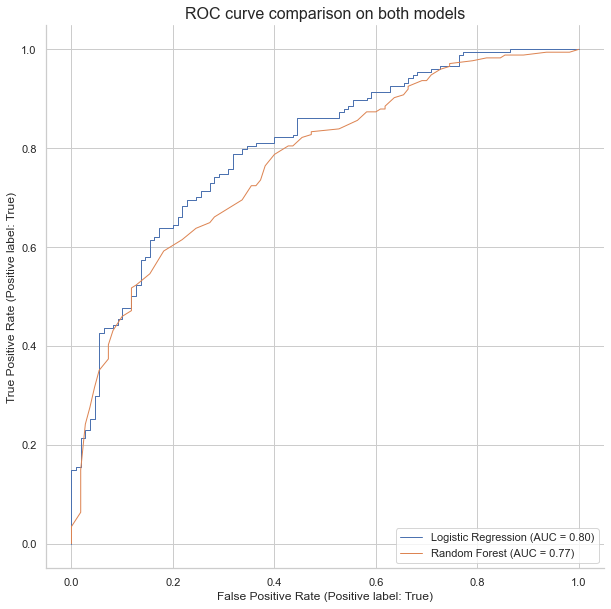

In [78]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('ROC curve comparison on both models')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

RocCurveDisplay.from_estimator(estimator=pipeline_lr, X=X_test, y=y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(estimator=pipeline_rf, X=X_test, y=y_test, name='Random Forest', ax=ax)
fig.savefig('non-crossed_ROC_curve_bechnmark.png')

#### 5.3. Cross val scores

##### 5.3.1 Complete computation

Using cross-validation will able us to score our models more robustly.

In [68]:
# update rf to lr_extended => idea is to differentiate the 2 LR models to see if there is a use of the extended model

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score

skf = StratifiedKFold(n_splits=5)

X = train_set[FEATURES]  # was .reset_index()
y = train_set[LABEL]

Xvals = train_set[FEATURES].values  # was .reset_index()
yvals = train_set[LABEL].values
catvals = train_set[CAT_FEATURES].values   # category label is used for stratifying

#splits = kf.split(X)
#splits = skf.split(Xvals, catvals)

scores_lr = cross_val_score(pipeline_lr, X, y.values.ravel(), cv=skf)
scores_lr_mean = np.mean(scores_lr)
print(f'mean of scores on simple Log Regression model: {scores_lr_mean.round(2)}')

scores_rf = cross_val_score(pipeline_rf, X, y.values.ravel(), cv=skf)
scores_rf_mean = np.mean(scores_rf)
print(f'mean of scores on ensemble Random Forest model: {scores_rf_mean.round(2)}')

mean of scores on simple Log Regression model: 0.76
mean of scores on ensemble Random Forest model: 0.75


In [69]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

X = train_set[FEATURES].values
y = train_set[LABEL].values
cat = train_set[CAT_FEATURES].values   # category label is used for stratifying

splits = skf.split(X, cat)

# define models list
models = [pipeline_lr, pipeline_rf]
models_names = ['logistic_regression', 'random_forest']

# preds metrics
accuracies_lr, accuracies_rf, class_reports_cv = [], [], []

X_vals_df, y_vals_df = pd.DataFrame(), pd.DataFrame()
y_preds_df = pd.DataFrame()
y_probs_df = pd.DataFrame()

# probs metrics
falses_df, trues_df = pd.DataFrame(), pd.DataFrame()
corrects_df, losses_df = pd.DataFrame(), pd.DataFrame()

counter = 0

for train_cv_index, val_index in splits: 

    counter += 1
    X_train_cv, y_train_cv = X[train_cv_index], y[train_cv_index]
    X_val, y_val = X[val_index], y[val_index]

    for model, model_name in zip(models, models_names):
    # LOOP on both models

        # appending X_vals_df and y_vals_df on each model
        X_vals_df = pd.concat([X_vals_df, pd.DataFrame(X_val)], axis=0)
        y_vals_df = pd.concat([y_vals_df, pd.DataFrame(y_val)], axis=0)

        model.fit(X_train_cv, y_train_cv.ravel())

        # preds
        y_pred_cv = model.predict(X_val)
        y_preds_df = pd.concat([y_preds_df, pd.Series(y_pred_cv)], axis=0)   # at the end we will concatenate on axis=1 : X_vals_df, y_vals_df, y_preds_df

        # preds metrics, score
        score = model.score(X_val, y_val)
        if model_name == 'logistic_regression':
            accuracies_lr.append(score)
        else:  # sole other case is random forest
            accuracies_rf.append(score)

        # preds metrics, classification_report
        class_rep_cv = pd.DataFrame(classification_report(y_val, y_pred_cv, output_dict=True)).reset_index().rename(columns={'index':'metric'}).round(2)
        class_rep_cv['trial'] = counter
        class_rep_cv['model'] = model_name   # update with 'model' from the loop
        class_reports_cv.append(class_rep_cv)

        # probs
        y_prob_cv = model.predict_proba(X_val)   # generates one 2D-array with 2 columns, one for Label = 0, one for Label = 1 (True)

        # calculating 'falses' for to selected model and appending falses_df
        falses = pd.DataFrame(y_prob_cv[:,0])   # falses specific to selected model
        falses['model'] = model_name
        falses['trial'] = counter
        falses_df = pd.concat([falses_df, falses], axis=0)

        # calculating 'trues' for to selected model and appending trues_df
        trues = pd.DataFrame(y_prob_cv[:,1])   # trues specific to selected model
        trues_df = pd.concat([trues_df, trues], axis=0)

        # calculating 'corrects' for to selected model and appending corrects_df - corrects are the correct predictions, either in column false or in column true
        corrects_list = []
        for i in range(len(y_val)):
            correct_i = y_val[i,0] * trues.iloc[i,0] + (1 - y_val[i,0]) * (1 - trues.iloc[i,0])
            corrects_list.append(correct_i)
        corrects = pd.Series(corrects_list)  # could be integrated in following line
        corrects_df = pd.concat([corrects_df, corrects], axis=0)

        # calculating 'losses' for selected model and appending losses_df
        losses_list = []
        eps=1e-14  # defining an epsilon value - close to zero - for the clip function (see below)
        for i in range(len(y_val)):
            predicted = np.clip(trues.iloc[i,0], eps, 1 - eps)  # replacing trues[i] by 'predicted' var avoids getting 0 to pass to log
            loss_i = -1 * (y_val[i,0] * np.log(predicted) + (1 - y_val[i,0]) * np.log(1 - predicted))
            losses_list.append(loss_i)
        losses = pd.Series(losses_list)  # could be integrated in following line
        losses_df = pd.concat([losses_df, losses], axis=0)

# concatenate all columns for proba results

falses_df.columns = ['probs_false', 'model', 'trial']
trues_df.columns = ['probs_true']
corrects_df.columns = ['probs_correct']
losses_df.columns = ['losses']
y_probs_df = pd.concat([falses_df[['model', 'trial', 'probs_false']], trues_df, corrects_df, losses_df], axis=1)  # models and trials are tracked in falses_df

X_vals_df.columns = FEATURES
y_vals_df.columns = LABEL
y_preds_df.columns = ['Preds']

conso_results = pd.concat([X_vals_df, y_vals_df, y_preds_df, y_probs_df], axis=1).round(3)

##### 5.3.2 General performance overview

In [70]:
conso_results.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Preds,model,trial,probs_false,probs_true,probs_correct,losses
0,86.02,31.49,1.27,6.72,Lunch/Snacks,6,True,True,logistic_regression,1,0.328,0.672,0.672,0.398
1,0.76,1.9,3.76,0.05,Vegetable,2,True,True,logistic_regression,1,0.044,0.956,0.956,0.046
2,1177.94,48.25,0.78,18.3,Pork,2,True,True,logistic_regression,1,0.087,0.913,0.913,0.091
3,470.68,2.71,3.92,31.4,Breakfast,1,False,False,logistic_regression,1,0.691,0.309,0.691,0.370
4,858.67,5.07,7.47,1.84,Lunch/Snacks,1,True,True,logistic_regression,1,0.346,0.654,0.654,0.425


In [71]:
pd.concat(class_reports_cv).head()

,metric,False,True,accuracy,macro avg,weighted avg,trial,model
0,precision,0.63,0.72,0.69,0.68,0.69,1,logistic_regression
1,recall,0.61,0.74,0.69,0.68,0.69,1,logistic_regression
2,f1-score,0.62,0.73,0.69,0.68,0.69,1,logistic_regression
3,support,28.00,39.00,0.69,67.00,67.00,1,logistic_regression
0,precision,0.68,0.74,0.72,0.71,0.71,1,random_forest


In [72]:
print('accuracy on both models:')
display(pd.concat(class_reports_cv).groupby('model').accuracy.mean())
print('\nother metrics :')
pd.concat(class_reports_cv).groupby(['model','metric'])[['False','True', 'weighted avg']].mean().round(2)

accuracy on both models:


model
logistic_regression    0.751
random_forest          0.746
Name: accuracy, dtype: float64


other metrics :


False   True  weighted avg
model               metric                               
logistic_regression f1-score    0.66   0.80          0.75
                    precision   0.73   0.76          0.75
                    recall      0.60   0.85          0.75
                    support    26.30  39.90         66.20
random_forest       f1-score    0.66   0.80          0.74
                    precision   0.71   0.77          0.75
                    recall      0.63   0.83          0.75
                    support    26.30  39.90         66.20

F1-score (valuable since the class labels are inbalanced) is close to 0.8 on True Labels for the best model, meaning we detect High-traffic potential.<br>
Logistic Regression is better on almost all metrics, including Log Loss.

In [73]:
# simple way of calculation for sanity-check
print(f'accuracies mean for Logistic Regression : {np.mean(accuracies_lr).round(2)}')
print(f'accuracies mean for Random Forest : {np.mean(accuracies_rf).round(2)}')

accuracies mean for Logistic Regression : 0.75
accuracies mean for Random Forest : 0.75


##### 5.3.3 Segmented performance (for Datascience Team)

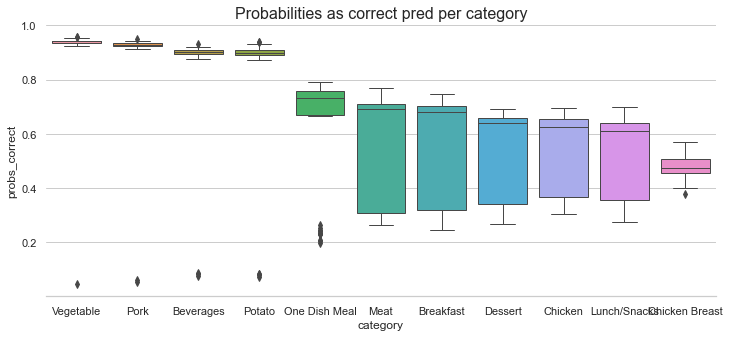

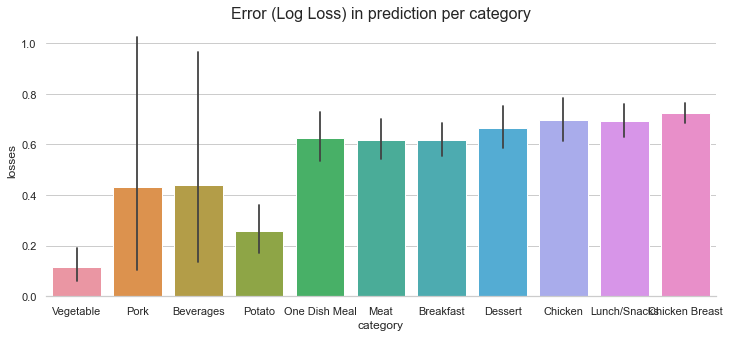

In [91]:
cat_sorted_results = conso_results[conso_results.model == 'logistic_regression'].groupby('category')['probs_correct'].median().sort_values(ascending=False)

with sns.axes_style("whitegrid"):
    fig1, ax = plt.subplots(figsize=(12, 5))
    sns.despine(left=True)
    ax = sns.boxplot(data = conso_results[conso_results.model == 'logistic_regression'], x='category', y='probs_correct', order=cat_sorted_results.index)
    ax.set_title('Probabilities as correct pred per category')
    fig1.savefig('crossed_correct_probs_vs_category.png')

    fig2, ax = plt.subplots(figsize=(12, 5))
    sns.despine(left=True)
    ax = sns.barplot(data = conso_results, x='category', y='losses', order=cat_sorted_results.index)
    ax.set_title('Error (Log Loss) in prediction per category')
    fig2.savefig('crossed_logloss_vs_category.png')

We can notice quite big differences in predictions between categories, despite an effort to impute missing value means on each of them.<br><br>
We are able to predict correct labels (whether it's True or False) with a very good level on 4 categories :<br>
Vegetable, Beverages, Potato and Pork.<br><br>
On other categories, we have much higher dispersion in results, that range between 50% and 70% of good predictions.<br>
Error level, though non catastrophic, is higher also.

### 6\. Metric for the business to monitor

In [75]:
import matplotlib.ticker as mtick


popular_recipes_cat_servings:


,1,2,4,6
category,,,,
One Dish Meal,NaN,1.0,NaN,NaN
Pork,7.0,11.0,26.0,15.0
Potato,10.0,8.0,26.0,16.0
Vegetable,5.0,13.0,30.0,10.0



all_recipes_cat_sorted :


,high_traffic
category,
Breakfast,75
Chicken Breast,69
Beverages,65
Lunch/Snacks,61
Potato,60
Pork,59
Dessert,58
Vegetable,58
Meat,55


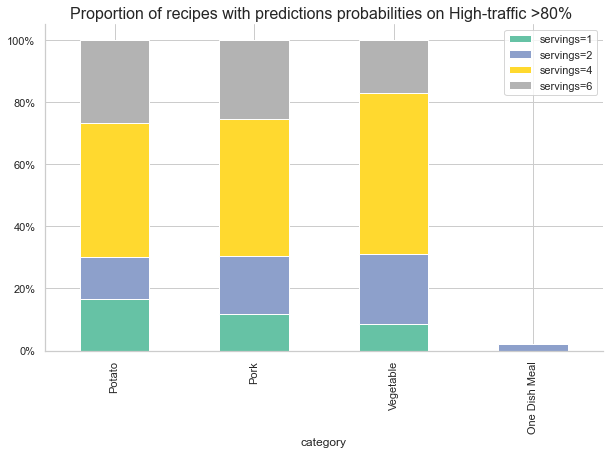

In [85]:
# filter on 'logistic regression' model (best) and probs greater than 80% on True Labels
popular_recipes = conso_results[(conso_results.model == 'logistic_regression') & (conso_results.probs_true > 0.80)]

# group recipe counts by category and servings
popular_recipes_cat_servings = popular_recipes.groupby(['category', 'servings'])['high_traffic'].count()
popular_recipes_cat_servings = pd.DataFrame(popular_recipes_cat_servings).reset_index(level='servings').pivot(columns='servings')

# lower the multi-index column names to one level
popular_recipes_cat_servings.columns = [c for (v, c) in popular_recipes_cat_servings.columns]

# define logical order for category
popular_recipes_cat_servings_sorted = popular_recipes_cat_servings.sum(axis=1).sort_values(ascending=False)

#print(popular_recipes_cat_servings_sorted)
print('\npopular_recipes_cat_servings:')
display(popular_recipes_cat_servings)

all_recipes = conso_results[(conso_results.model == 'logistic_regression')]
all_recipes_cat_sorted = all_recipes.groupby('category')['high_traffic'].count().sort_values(ascending=False)
all_recipes_cat_sorted = pd.DataFrame(all_recipes_cat_sorted)
print('\nall_recipes_cat_sorted :')
display(all_recipes_cat_sorted)


# plotting results
popular_vs_all = pd.merge(popular_recipes_cat_servings, all_recipes_cat_sorted, how='left', left_index=True, right_index=True)
perc_popular_categ_servings_vs_all = popular_vs_all.transform(lambda x: x/popular_vs_all['high_traffic']*100).drop(columns='high_traffic')
perc_popular_categ_servings_vs_all = perc_popular_categ_servings_vs_all.assign(
    sum = perc_popular_categ_servings_vs_all.sum(axis=1)).sort_values('sum', ascending=False).drop(columns='sum')
perc_popular_categ_servings_vs_all = perc_popular_categ_servings_vs_all.rename(columns={'1': 'servings=1', '2': 'servings=2', '4': 'servings=4', '6': 'servings=6'})

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.despine()
    perc_popular_categ_servings_vs_all.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
    ax.set_title('Proportion of recipes with predictions probabilities on High-traffic >80% ')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    fig.savefig('probs_categ_servings_80perc_popularity.png')
    

Recipes that are generating High Traffic 80% of the time are concentrated on 3 categories :<br>
Potato, Pork and Vegetable<br>
This graph also shows the proportion on size of servings. <br><br>
So Product Management should concentrate on showing on the homepage those 3 categories of recipes, with a focus on bigger servings-sizes.